Can daily average U.S. flight delays be accurately predicted using time-based models, and does a complex time-series model (Prophet) outperform a simpler Linear Regression approach?

Linear Regression vs Prophet | Flight Delay Analysis

Importing Libraries and Loading Data
Aggregating to Daily Data and Cleaning

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv('flights.csv')

df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

daily_data = df.groupby('DATE').agg({
    'ARRIVAL_DELAY': 'mean',
    'DEPARTURE_DELAY': 'mean',
    'CANCELLED': 'sum',
    'FLIGHT_NUMBER': 'count'
}).reset_index()

daily_data.columns = ['date', 'avg_arrival_delay', 'avg_departure_delay', 
                      'total_cancelled', 'total_flights']

daily_data = daily_data.dropna(subset=['avg_arrival_delay'])

mean_delay = daily_data['avg_arrival_delay'].mean()
std_delay = daily_data['avg_arrival_delay'].std()
daily_data = daily_data[
    (daily_data['avg_arrival_delay'] >= mean_delay - 3*std_delay) & 
    (daily_data['avg_arrival_delay'] <= mean_delay + 3*std_delay)
]

print(f"Dataset shape: {daily_data.shape}")
print(f"Date range: {daily_data['date'].min()} to {daily_data['date'].max()}")

C:\Users\thece\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'flights.csv'

Feature Engineering for Linear Regression

In [ ]:
lr_data = daily_data.copy()

lr_data['day_of_week'] = lr_data['date'].dt.dayofweek
lr_data['month'] = lr_data['date'].dt.month
lr_data['day_of_month'] = lr_data['date'].dt.day
lr_data['week_of_year'] = lr_data['date'].dt.isocalendar().week
lr_data['is_weekend'] = (lr_data['day_of_week'] >= 5).astype(int)

lr_data['days_since_start'] = (lr_data['date'] - lr_data['date'].min()).dt.days

lr_data['delay_lag_1'] = lr_data['avg_arrival_delay'].shift(1)
lr_data['delay_lag_7'] = lr_data['avg_arrival_delay'].shift(7)
lr_data['delay_lag_30'] = lr_data['avg_arrival_delay'].shift(30)

lr_data['rolling_avg_7'] = lr_data['avg_arrival_delay'].rolling(window=7, min_periods=1).mean()
lr_data['rolling_avg_30'] = lr_data['avg_arrival_delay'].rolling(window=30, min_periods=1).mean()

lr_data['month_sin'] = np.sin(2 * np.pi * lr_data['month'] / 12)
lr_data['month_cos'] = np.cos(2 * np.pi * lr_data['month'] / 12)
lr_data['day_of_week_sin'] = np.sin(2 * np.pi * lr_data['day_of_week'] / 7)
lr_data['day_of_week_cos'] = np.cos(2 * np.pi * lr_data['day_of_week'] / 7)

lr_data = lr_data.dropna()

print(f"Shape after feature engineering: {lr_data.shape}")

After feature engineering: (333, 20)


Train-Test Split

In [ ]:
split_date = lr_data['date'].quantile(0.8)

train_data = lr_data[lr_data['date'] <= split_date]
test_data = lr_data[lr_data['date'] > split_date]

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")
print(f"Split date: {split_date}")

Training samples: 266
Testing samples: 67
Split date: 2015-10-24 14:24:00


Training Linear Regression

In [ ]:
feature_columns = [
    'day_of_week', 'month', 'day_of_month', 'week_of_year', 'is_weekend',
    'days_since_start', 'delay_lag_1', 'delay_lag_7', 'delay_lag_30',
    'rolling_avg_7', 'rolling_avg_30', 'month_sin', 'month_cos',
    'day_of_week_sin', 'day_of_week_cos', 'total_flights',
    'avg_departure_delay', 'total_cancelled'
]

X_train = train_data[feature_columns]
y_train = train_data['avg_arrival_delay']

X_test = test_data[feature_columns]
y_test = test_data['avg_arrival_delay']

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)

lr_r2 = r2_score(y_test, lr_predictions)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
lr_mae = mean_absolute_error(y_test, lr_predictions)

print("\n=== Linear Regression Results ===")
print(f"R² Score: {lr_r2:.4f}")
print(f"RMSE: {lr_rmse:.2f} minutes")
print(f"MAE: {lr_mae:.2f} minutes")

NameError: name 'train_data' is not defined

Training Prophet

19:00:38 - cmdstanpy - INFO - Chain [1] start processing
19:00:38 - cmdstanpy - INFO - Chain [1] done processing



=== Prophet Results ===
R² Score: -0.7872
RMSE: 10.28 minutes
MAE: 6.87 minutes


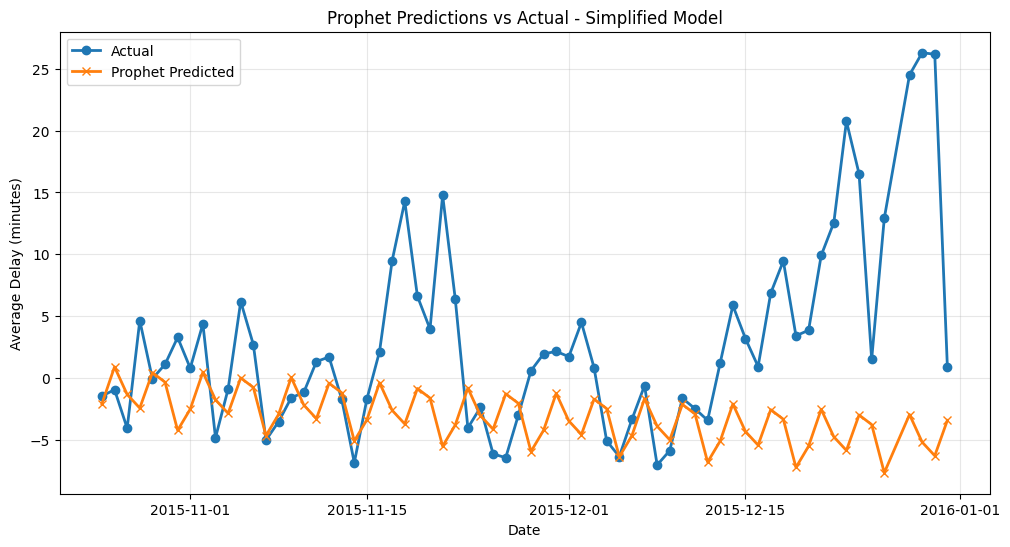

In [ ]:
prophet_data = daily_data[['date', 'avg_arrival_delay']].copy()
prophet_data.columns = ['ds', 'y']

prophet_train = prophet_data[prophet_data['ds'] <= split_date]
prophet_test = prophet_data[prophet_data['ds'] > split_date]

prophet_model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1
)
prophet_model.fit(prophet_train)

prophet_forecast = prophet_model.predict(prophet_test)

prophet_predictions = prophet_forecast['yhat'].values
prophet_r2 = r2_score(prophet_test['y'], prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_predictions))
prophet_mae = mean_absolute_error(prophet_test['y'], prophet_predictions)

print("\n=== Prophet Results ===")
print(f"R² Score: {prophet_r2:.4f}")
print(f"RMSE: {prophet_rmse:.2f} minutes")
print(f"MAE: {prophet_mae:.2f} minutes")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(prophet_test['ds'], prophet_test['y'], label='Actual', linewidth=2, marker='o')
ax.plot(prophet_test['ds'], prophet_predictions, label='Prophet Predicted', linewidth=2, marker='x')
ax.set_title('Prophet Predictions vs Actual - Simplified Model')
ax.set_xlabel('Date')
ax.set_ylabel('Average Delay (minutes)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

Comparison Visualization

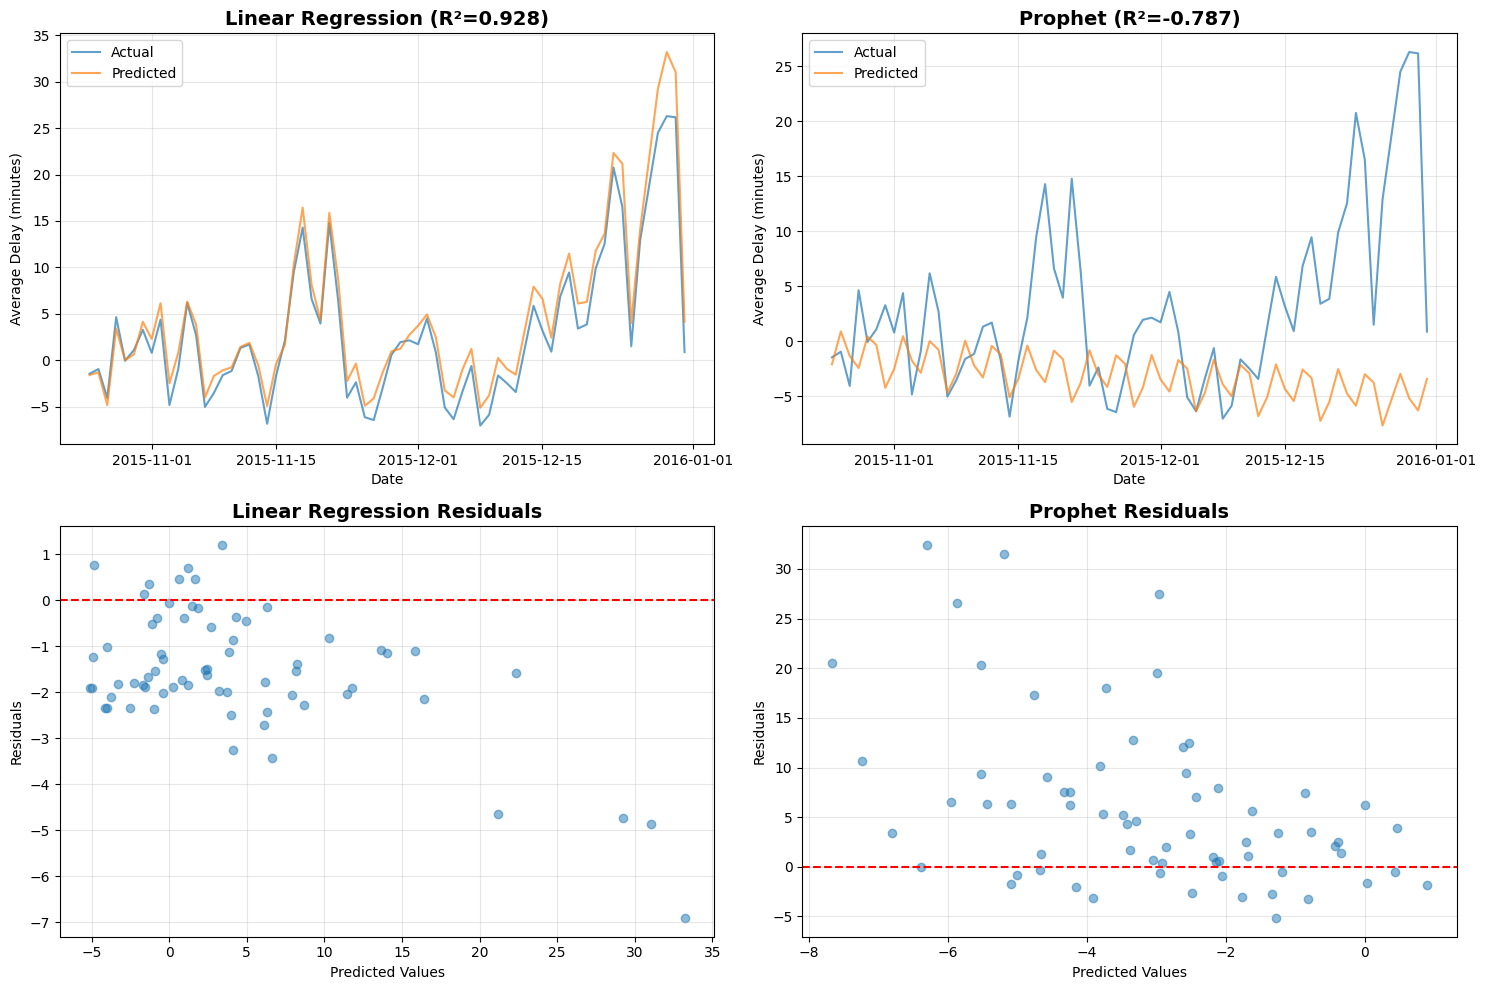

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(test_data['date'], y_test, label='Actual', alpha=0.7)
axes[0, 0].plot(test_data['date'], lr_predictions, label='Predicted', alpha=0.7)
axes[0, 0].set_title(f'Linear Regression (R²={lr_r2:.3f})', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Average Delay (minutes)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(prophet_test['ds'], prophet_test['y'], label='Actual', alpha=0.7)
axes[0, 1].plot(prophet_test['ds'], prophet_predictions, label='Predicted', alpha=0.7)
axes[0, 1].set_title(f'Prophet (R²={prophet_r2:.3f})', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Average Delay (minutes)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

lr_residuals = y_test - lr_predictions
axes[1, 0].scatter(lr_predictions, lr_residuals, alpha=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_title('Linear Regression Residuals', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Values')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

prophet_residuals = prophet_test['y'].values - prophet_predictions
axes[1, 1].scatter(prophet_predictions, prophet_residuals, alpha=0.5)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_title('Prophet Residuals', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prophet_vs_linear_regression.png', dpi=300, bbox_inches='tight')
plt.show()

Linear Regression performed better than Prophet in this scenario. 

Flight delays don't follow strong seasonal patterns in the same way that sales or website traffic do.
Delays are more dependent on immediate factors (weather, aircraft availability, previous delays) rather than time-of-year patterns.
The dataset only covers one year (2015), so Prophet couldn't learn strong yearly seasonality
Prophet excels at data with regular, predictable seasonal cycles.

Accurate delay forecasting can inform staffing, scheduling, and customer communication strategies within airline operations.


Linear Regression (R² = 0.9276) significantly outperformed Prophet (R² = -0.7872)